In [9]:
import os
import numpy as np
import cv2
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [10]:
# ✅ Unzip your uploaded file
zip_path = "/content/archive (1).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("flowers_data")

In [13]:
# ✅ Unzip your uploaded file
zip_path = "/content/test_images.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("test_data")

In [14]:
predict_data = "/content/test_data/test_images"

In [11]:
#  Point to the actual extracted folder
DATASET_DIR = "flowers_data/flowers"

In [91]:
# Image size
IMG_SIZE = 150

In [92]:
# Define flower classes
CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [167]:
FLOWER_DIRS = {flower: os.path.join(DATASET_DIR, flower) for flower in CLASSES}
FLOWER_DIRS

{'daisy': 'flowers_data/flowers/daisy',
 'dandelion': 'flowers_data/flowers/dandelion',
 'rose': 'flowers_data/flowers/rose',
 'sunflower': 'flowers_data/flowers/sunflower',
 'tulip': 'flowers_data/flowers/tulip'}

In [94]:
# Creating Empty Lists
X = []  #To store all the images
Z = []  #To store all the flower labels (like "rose", "daisy")


In [95]:
# Assign label function
def assign_label(img_name, flower_type):
    return flower_type

In [96]:
def make_train_data(flower_type, DIR):
    if not os.path.exists(DIR):
        print(f"❌ Directory does not exist: {DIR}")
        return

    for img_name in tqdm(os.listdir(DIR), desc=f"Loading {flower_type}"):
        path = os.path.join(DIR, img_name)

        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(np.array(img))
        Z.append(str(flower_type))

In [97]:
# ✅ Load all flowers
for flower in CLASSES:
    make_train_data(flower, FLOWER_DIRS[flower])

print(f"\n Loaded total images: {len(X)}") # Should be close to 4317

Loading tulip: 100%|██████████| 984/984 [00:02<00:00, 486.85it/s]


 Loaded total images: 4317


In [170]:
# Convert X and Z to numpy arrays
X = np.array(X, dtype=np.float32)
Z = np.array(Z)
Z[:-5]

array(['daisy', 'daisy', 'daisy', ..., 'tulip', 'tulip', 'tulip'],
      dtype='<U9')

In [99]:
# Label encode
le = LabelEncoder()
Y = le.fit_transform(Z)

In [100]:
# Convert labels to categorical (one-hot encoding)
Y = to_categorical(Y, 5)

In [173]:
# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)
Y_train[0:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [102]:
print(f"x_train shape: {X_train.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"x_test shape: {X_test.shape}")
print(f"y_test shape: {Y_test.shape}")


x_train shape: (3237, 150, 150, 3)
y_train shape: (3237, 5)
x_test shape: (1080, 150, 150, 3)
y_test shape: (1080, 5)


In [103]:
# NEW: Handle Class Imbalance
# ----------------------------------------
from sklearn.utils import class_weight

Y_train_labels = np.argmax(Y_train, axis=1)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_labels),
    y=Y_train_labels
)

class_weights = dict(enumerate(class_weights_array))

print("✅ Computed Class Weights:", class_weights)

✅ Computed Class Weights: {0: np.float64(1.1298429319371728), 1: np.float64(0.820532319391635), 2: np.float64(1.1010204081632653), 3: np.float64(1.1792349726775957), 4: np.float64(0.8772357723577235)}


In [104]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [105]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [106]:
#Load the Pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [107]:
# ❄️ Freeze all layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False


In [108]:
#Add Your Own Custom Layers
x = data_augmentation(base_model.output)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)


In [109]:
#Define the Full Model
model = Model(inputs=base_model.input, outputs=predictions)


In [110]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [111]:
# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=1e-6)

In [112]:
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 26,213,253 (100.00 MB)

 Trainable params: 2,625,541 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [113]:
# Train the Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint, lr_reduce],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6642 - loss: 0.8755

102/102 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.6653 - loss: 0.8729 - val_accuracy: 0.8250 - val_loss: 0.4872 - learning_rate: 1.0000e-04
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8906 - loss: 0.2872

102/102 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - accuracy: 0.8907 - loss: 0.2869 - val_accuracy: 0.8509 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9564 - loss: 0.1485

102/102 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.9563 - loss: 0.1485 - val_accuracy: 0.8602 - val_loss: 0.4006 - learning_rate: 1.0000e-04
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9869 - loss: 0.0833

102/102 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.9869 - loss: 0.0833 - val_accuracy: 0.8657 - val_loss: 0.3906 - learning_rate: 1.0000e-04
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9936 - loss: 0.0548 - val_accuracy: 0.8509 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9974 - loss: 0.0379

102/102 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.9974 - loss: 0.0379 - val_accuracy: 0.8676 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9979 - loss: 0.0272

102/102 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.9979 - loss: 0.0272 - val_accuracy: 0.8704 - val_loss: 0.4054 - learning_rate: 1.0000e-04
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9997 - loss: 0.0156
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
102/102 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.9997 - loss: 0.0156 - val_accuracy: 0.8648 - val_loss: 0.4220 - learning_rate: 1.0000e-04
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.9993 - loss: 0.0133 - val_accuracy: 0.8685 - val_loss: 0.4067 - learning_rate: 2.0000e-05
Epoch 10/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.9994 - loss: 0.0111 - val_accuracy: 0.8685 - val_loss: 0.4066 - learning_rate: 2.0000e-05
Epoch 11/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.9992 - loss: 0.0103 - val_accuracy: 0.8704 - val_loss: 0.4095 - learning_rate: 2.0000e-05


In [114]:
# 8. Fine-Tuning Phase
# ----------------------------------------
# Unfreeze last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning training
fine_tune_history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop, checkpoint, lr_reduce],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - accuracy: 0.9196 - loss: 0.2760 - val_accuracy: 0.8648 - val_loss: 0.3688 - learning_rate: 1.0000e-05
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 630s 6s/step - accuracy: 0.9782 - loss: 0.1255 - val_accuracy: 0.8667 - val_loss: 0.3634 - learning_rate: 1.0000e-05
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9853 - loss: 0.0812

102/102 ━━━━━━━━━━━━━━━━━━━━ 658s 6s/step - accuracy: 0.9853 - loss: 0.0811 - val_accuracy: 0.8741 - val_loss: 0.3565 - learning_rate: 1.0000e-05
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 637s 6s/step - accuracy: 0.9988 - loss: 0.0483 - val_accuracy: 0.8731 - val_loss: 0.3520 - learning_rate: 1.0000e-05
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 586s 6s/step - accuracy: 0.9963 - loss: 0.0326 - val_accuracy: 0.8741 - val_loss: 0.3505 - learning_rate: 1.0000e-05
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 569s 5s/step - accuracy: 0.9967 - loss: 0.0270 - val_accuracy: 0.8694 - val_loss: 0.3577 - learning_rate: 1.0000e-05
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.9982 - loss: 0.0185 - val_accuracy: 0.8713 - val_loss: 0.3680 - learning_rate: 1.0000e-05
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 584s 6s/step - accuracy: 0.9998 - loss: 0.0120 - val_accuracy: 0.8713 - val_loss: 0.3620 - learning_rate: 1.0000e-05
Epoch 9/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9986

In [115]:
model.save('flower_classifier.keras')


In [116]:
from google.colab import files
files.download('flower_classifier.keras')  # or .h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
from tensorflow.keras.models import load_model
import pickle

model = load_model('/content/flower.h5')  # Or the path from your Drive
lb = pickle.loads(open('/content/lav labels', "rb").read)

In [118]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"\n🎯 Test Accuracy: {accuracy:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8606 - loss: 0.4014

🎯 Test Accuracy: 0.8741


In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

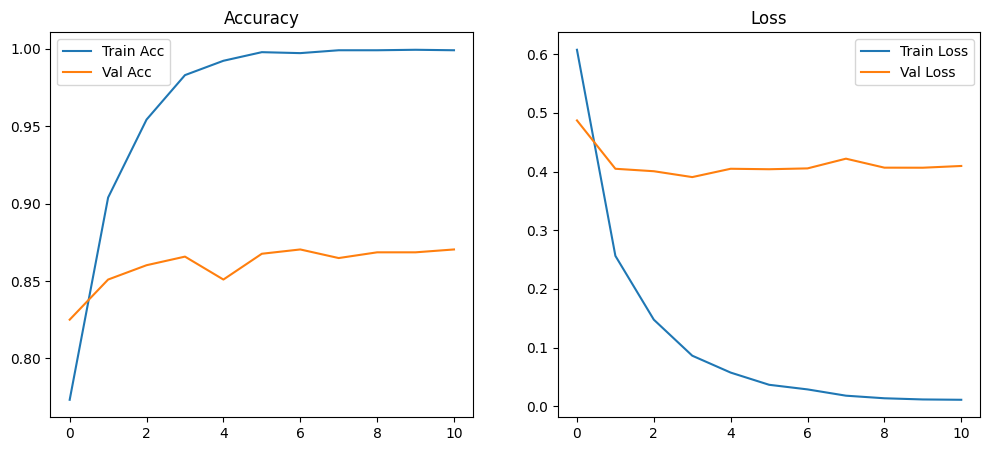

In [120]:
# Plot accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step

📊 Classification Report:
              precision    recall  f1-score   support

       daisy       0.89      0.88      0.88       191
   dandelion       0.94      0.90      0.92       263
        rose       0.83      0.84      0.84       196
   sunflower       0.86      0.89      0.88       184
       tulip       0.84      0.85      0.85       246

    accuracy                           0.87      1080
   macro avg       0.87      0.87      0.87      1080
weighted avg       0.88      0.87      0.87      1080



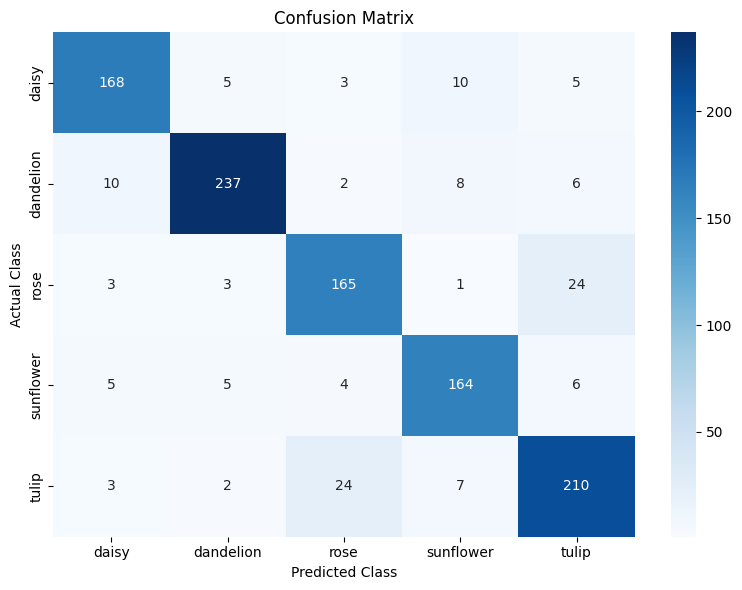

In [121]:
# Step 1: Predict labels on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices
y_true = np.argmax(Y_test, axis=1)        # true class indices

# Step 2: Print classification report
target_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.show()


In [46]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
import zipfile

In [55]:
import shutil

# Delete previous extracted test folder if it exists
if os.path.exists('/content/test_images'):
    shutil.rmtree('/content/test_images')
    print("🧹 Old extracted test images removed!")


🧹 Old extracted test images removed!


In [57]:

extract_folder = "/content/test_images"

os.makedirs(extract_folder, exist_ok=True)

In [58]:
from tensorflow.keras.models import load_model
import pickle

model = load_model('/content/flower.h5')  # Or the path from your Drive
lb = pickle.loads(open('/content/lav labels', "rb").read())
print("✅ Model loaded successfully.")

✅ Model loaded successfully.


In [61]:
def predict_flower(image_path):
    # Read and preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img_norm = img / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    # Predict
    predictions = model.predict(img_input)
    class_idx = np.argmax(predictions)
    print(class_idx)
    c=lb.classes_[class_idx]
    print(c)

    # Plot
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {flower_classes[class_idx]} ({predictions[0][class_idx]*100:.2f}%)")
    plt.show()

    # Print all class probabilities
    print("Class probabilities:")
    for i, flower in enumerate(flower_classes):
        print(f" - {flower}: {predictions[0][i]*100:.2f}%")


📸 Predicting for: 133692329_c1150ed811_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
4
tulip


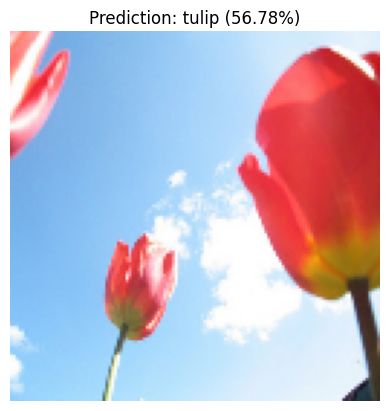

Class probabilities:
 - daisy: 15.40%
 - dandelion: 26.56%
 - rose: 0.26%
 - sunflower: 0.99%
 - tulip: 56.78%

📸 Predicting for: 24459548_27a783feda.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
0
daisy


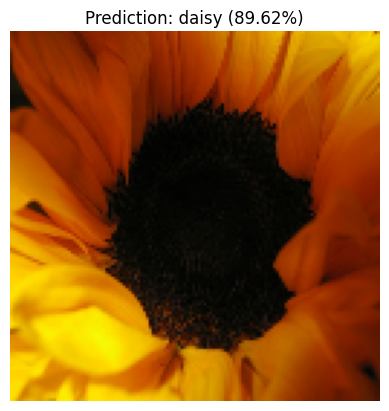

Class probabilities:
 - daisy: 89.62%
 - dandelion: 1.26%
 - rose: 0.58%
 - sunflower: 7.91%
 - tulip: 0.64%

📸 Predicting for: 5547758_eea9edfd54_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
0
daisy


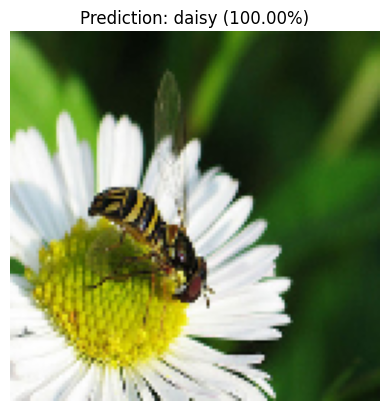

Class probabilities:
 - daisy: 100.00%
 - dandelion: 0.00%
 - rose: 0.00%
 - sunflower: 0.00%
 - tulip: 0.00%

📸 Predicting for: 112428919_f0c5ad7d9d_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
4
tulip


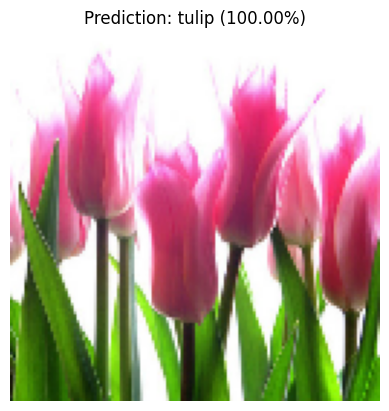

Class probabilities:
 - daisy: 0.00%
 - dandelion: 0.00%
 - rose: 0.00%
 - sunflower: 0.00%
 - tulip: 100.00%

📸 Predicting for: 13920113_f03e867ea7_m.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1
dandelion


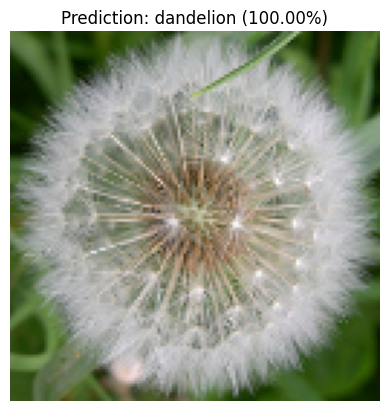

Class probabilities:
 - daisy: 0.00%
 - dandelion: 100.00%
 - rose: 0.00%
 - sunflower: 0.00%
 - tulip: 0.00%

📸 Predicting for: 44079668_34dfee3da1_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
3
sunflower


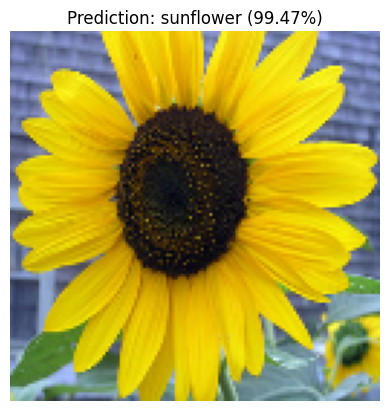

Class probabilities:
 - daisy: 0.53%
 - dandelion: 0.00%
 - rose: 0.00%
 - sunflower: 99.47%
 - tulip: 0.00%

📸 Predicting for: 5673551_01d1ea993e_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
3
sunflower


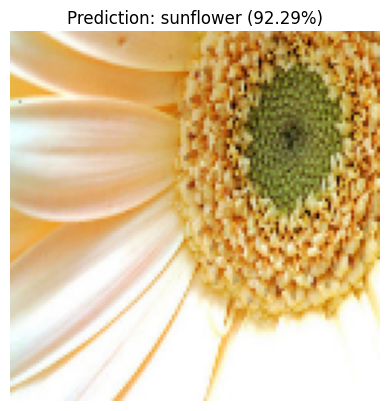

Class probabilities:
 - daisy: 6.16%
 - dandelion: 1.36%
 - rose: 0.12%
 - sunflower: 92.29%
 - tulip: 0.07%

📸 Predicting for: 11545123_50a340b473_m.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1
dandelion


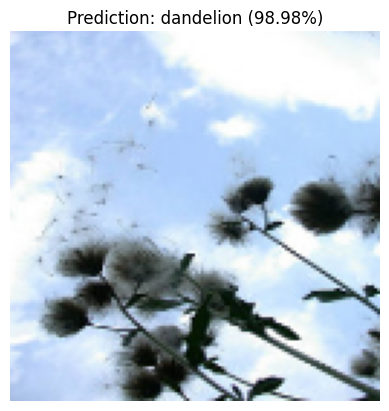

Class probabilities:
 - daisy: 0.92%
 - dandelion: 98.98%
 - rose: 0.05%
 - sunflower: 0.01%
 - tulip: 0.03%

📸 Predicting for: 466486216_ab13b55763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2
rose


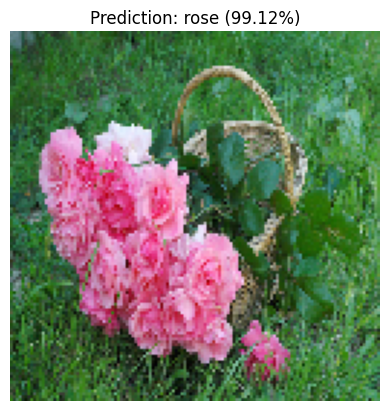

Class probabilities:
 - daisy: 0.00%
 - dandelion: 0.00%
 - rose: 99.12%
 - sunflower: 0.00%
 - tulip: 0.88%

📸 Predicting for: 459042023_6273adc312_n.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2
rose


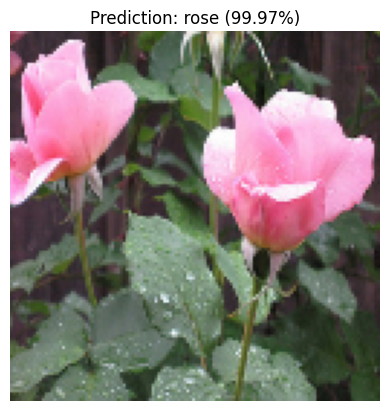

Class probabilities:
 - daisy: 0.00%
 - dandelion: 0.00%
 - rose: 99.97%
 - sunflower: 0.00%
 - tulip: 0.03%


In [62]:
def predict_all_images_in_folder(folder_path):
    image_extensions = ['jpg', 'jpeg', 'png']

    for root, dirs, files_in_dir in os.walk(folder_path):
        for file in files_in_dir:
            if file.split('.')[-1].lower() in image_extensions:
                file_path = os.path.join(root, file)
                print(f"\n📸 Predicting for: {file}")
                predict_flower(file_path)

# ----------------------------------------
# 7. RUN predictions!
# ----------------------------------------
predict_all_images_in_folder(extract_folder)

PyTorch Step-4 Code: Fine-Tuning Pretrained ResNet50

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔵 Using device: {device}")

🔵 Using device: cpu


In [17]:
# ⚡ Main training dataset (5 flowers)
train_dir = '/content/flowers_data/flowers'

# ⚡ Prediction images folder (random images)
predict_dir = '/content/test_data/test_images'

In [18]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ⚡ Prediction Transform (NO augmentation)
predict_transform = val_transform

In [19]:
full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
flower_classes = full_dataset.classes
print(f"✅ Flower Classes: {flower_classes}")


✅ Flower Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [20]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [21]:
# 6. Load Pre-trained ResNet50 and Modify
# ----------------------------------------
flower_model_pytorch = models.resnet50(pretrained=True)

# Freeze all layers
for param in flower_model_pytorch.parameters():
    param.requires_grad = False

# Replace Classifier Head
num_features = flower_model_pytorch.fc.in_features
flower_model_pytorch.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(flower_classes))  # Output 5 classes
)

flower_model_pytorch = flower_model_pytorch.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [22]:
# 7. Define Loss, Optimizer, Scheduler
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_model_pytorch.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
from tqdm import tqdm

num_epochs = 10
train_losses = []
val_losses = []
best_accuracy = 0.0

for epoch in range(num_epochs):
    flower_model_pytorch.train()
    running_loss = 0.0

    print(f"\n📚 Starting Epoch [{epoch+1}/{num_epochs}]...")

    # ➡️ PROPER Progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = flower_model_pytorch(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # ➡️ Update only ONE line
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(batch_loss=loss.item())

    # Epoch summary after full loop
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation after full training epoch
    flower_model_pytorch.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = flower_model_pytorch(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total

    # Full Epoch summary
    print(f"📅 Epoch [{epoch+1}/{num_epochs}] -- "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(flower_model_pytorch.state_dict(), '/content/best_flower_model_pytorch.pth')

print("\n✅ Finished Full Training!")




📚 Starting Epoch [1/10]...


Epoch [1/10]: 100%|██████████| 108/108 [08:34<00:00,  4.77s/it, batch_loss=0.336]


📅 Epoch [1/10] -- Train Loss: 0.6938, Val Loss: 0.4627, Val Accuracy: 0.8299

📚 Starting Epoch [2/10]...


Epoch [2/10]: 100%|██████████| 108/108 [08:25<00:00,  4.68s/it, batch_loss=0.428]


📅 Epoch [2/10] -- Train Loss: 0.4879, Val Loss: 0.4283, Val Accuracy: 0.8426

📚 Starting Epoch [3/10]...


Epoch [3/10]: 100%|██████████| 108/108 [08:26<00:00,  4.69s/it, batch_loss=0.348]


📅 Epoch [3/10] -- Train Loss: 0.4402, Val Loss: 0.4388, Val Accuracy: 0.8322

📚 Starting Epoch [4/10]...


Epoch [4/10]: 100%|██████████| 108/108 [08:28<00:00,  4.70s/it, batch_loss=0.321]


📅 Epoch [4/10] -- Train Loss: 0.4368, Val Loss: 0.4815, Val Accuracy: 0.8403

📚 Starting Epoch [5/10]...


Epoch [5/10]: 100%|██████████| 108/108 [08:24<00:00,  4.67s/it, batch_loss=0.153]


📅 Epoch [5/10] -- Train Loss: 0.3741, Val Loss: 0.4105, Val Accuracy: 0.8438

📚 Starting Epoch [6/10]...


Epoch [6/10]: 100%|██████████| 108/108 [08:26<00:00,  4.69s/it, batch_loss=0.524]


📅 Epoch [6/10] -- Train Loss: 0.3491, Val Loss: 0.4130, Val Accuracy: 0.8623

📚 Starting Epoch [7/10]...


Epoch [7/10]: 100%|██████████| 108/108 [08:29<00:00,  4.72s/it, batch_loss=0.474]


📅 Epoch [7/10] -- Train Loss: 0.3404, Val Loss: 0.4415, Val Accuracy: 0.8368

📚 Starting Epoch [8/10]...


Epoch [8/10]: 100%|██████████| 108/108 [08:40<00:00,  4.82s/it, batch_loss=0.249]


📅 Epoch [8/10] -- Train Loss: 0.3253, Val Loss: 0.4120, Val Accuracy: 0.8565

📚 Starting Epoch [9/10]...


Epoch [9/10]: 100%|██████████| 108/108 [08:45<00:00,  4.87s/it, batch_loss=0.322]


📅 Epoch [9/10] -- Train Loss: 0.3341, Val Loss: 0.4354, Val Accuracy: 0.8507

📚 Starting Epoch [10/10]...


Epoch [10/10]: 100%|██████████| 108/108 [08:54<00:00,  4.95s/it, batch_loss=0.19]


📅 Epoch [10/10] -- Train Loss: 0.3073, Val Loss: 0.4324, Val Accuracy: 0.8588

✅ Finished Full Training!


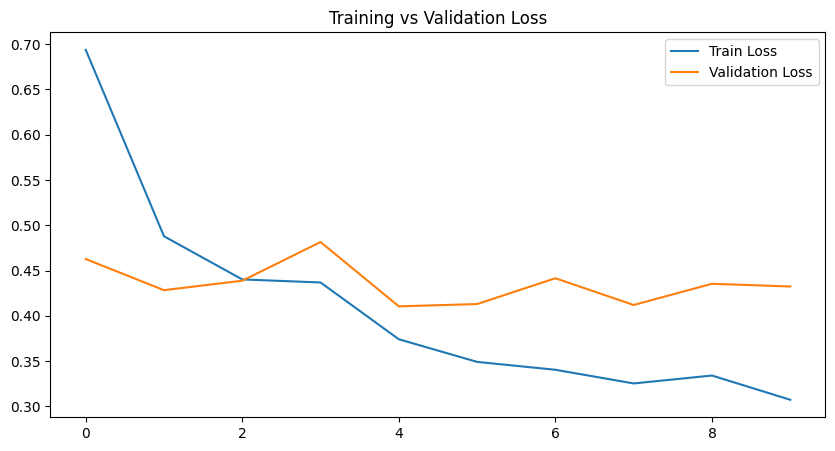

In [24]:
# 9. Loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()



In [28]:
# 10. Load best model

flower_model_pytorch.load_state_dict(torch.load('/content/best_flower_model_pytorch.pth'))
flower_model_pytorch.eval()
print("✅ Best model loaded for Testing!")

✅ Best model loaded for Testing!


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns




📊 Final Evaluation Metrics:
Accuracy: 0.8623
Precision: 0.8643
Recall: 0.8623
F1 Score: 0.8619

📋 Full Classification Report:
              precision    recall  f1-score   support

       daisy       0.89      0.82      0.86       158
   dandelion       0.89      0.92      0.90       225
        rose       0.77      0.85      0.81       137
   sunflower       0.87      0.93      0.90       144
       tulip       0.88      0.79      0.83       200

    accuracy                           0.86       864
   macro avg       0.86      0.86      0.86       864
weighted avg       0.86      0.86      0.86       864



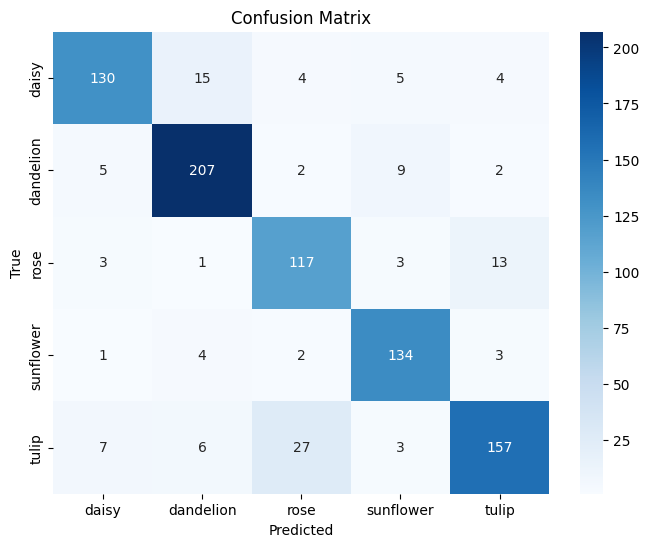

In [34]:
# 11. Final Evaluation on Validation Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = flower_model_pytorch(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n📊 Final Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
print("\n📋 Full Classification Report:")
print(classification_report(all_labels, all_preds, target_names=flower_classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=flower_classes, yticklabels=flower_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [35]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = predict_transform(image)
    image = image.unsqueeze(0).to(device)

    flower_model_pytorch.eval()

    with torch.no_grad():
        outputs = flower_model_pytorch(image)
        probs = torch.softmax(outputs, dim=1)
        predicted = torch.argmax(probs, dim=1)

    print(f"✅ Raw Model Output: {outputs.cpu().numpy()}")
    print(f"✅ Softmax Probabilities: {probs.cpu().numpy()}")
    print(f"✅ Predicted Class Index: {predicted.item()}")
    print(f"✅ Predicted Flower: {flower_classes[predicted.item()]}")

    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title(f"Prediction: {flower_classes[predicted.item()]}")
    plt.show()



📸 Predicting for: 133692329_c1150ed811_n.jpg
✅ Raw Model Output: [[-5.1024013 -3.7608438  1.2336633 -4.0220213  7.5885696]]
✅ Softmax Probabilities: [[3.0733820e-06 1.1755686e-05 1.7351409e-03 9.0535696e-06 9.9824095e-01]]
✅ Predicted Class Index: 4
✅ Predicted Flower: tulip


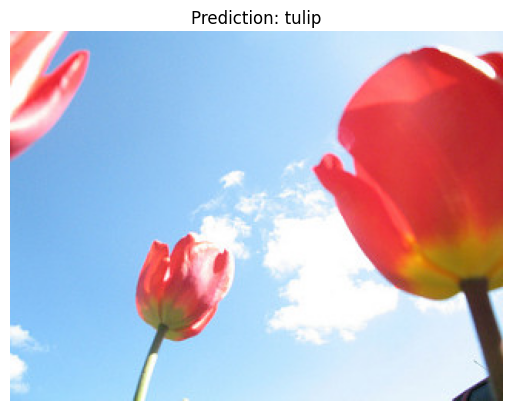


📸 Predicting for: 24459548_27a783feda.jpg
✅ Raw Model Output: [[-0.019065    0.41462    -0.93185884  1.3821845  -0.81298447]]
✅ Softmax Probabilities: [[0.13410805 0.20691971 0.05383114 0.5445149  0.06062615]]
✅ Predicted Class Index: 3
✅ Predicted Flower: sunflower


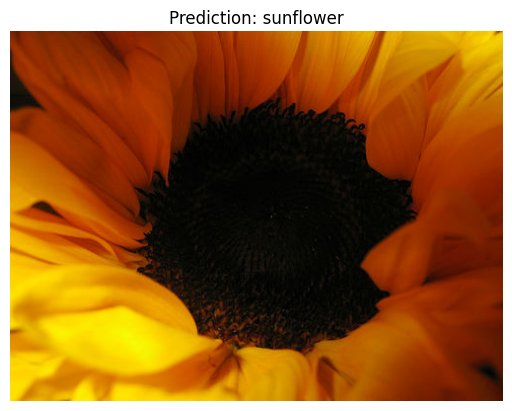


📸 Predicting for: 5547758_eea9edfd54_n.jpg
✅ Raw Model Output: [[ 6.5234895   2.734606   -4.626696   -0.43412057 -3.8591983 ]]
✅ Softmax Probabilities: [[9.7692728e-01 2.2098921e-02 1.4041004e-05 9.2941686e-04 3.0249506e-05]]
✅ Predicted Class Index: 0
✅ Predicted Flower: daisy


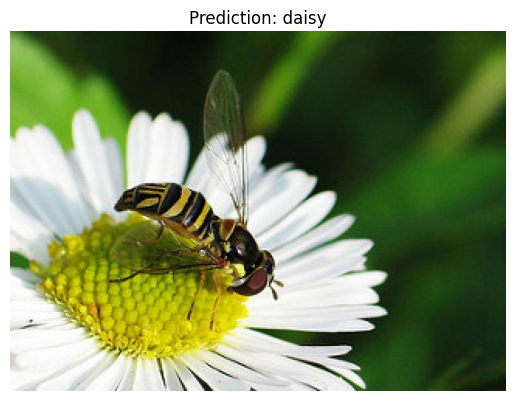


📸 Predicting for: 112428919_f0c5ad7d9d_n.jpg
✅ Raw Model Output: [[-2.6082118 -3.041734  -2.0143607 -4.5350847  8.647793 ]]
✅ Softmax Probabilities: [[1.2928828e-05 8.3807490e-06 2.3413451e-05 1.8824732e-06 9.9995339e-01]]
✅ Predicted Class Index: 4
✅ Predicted Flower: tulip


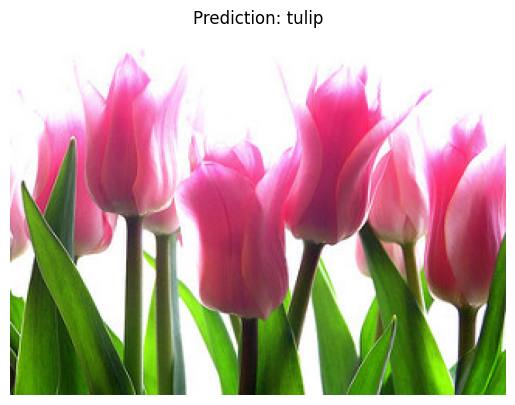


📸 Predicting for: 13920113_f03e867ea7_m.jpg
✅ Raw Model Output: [[-2.1106231 12.315033  -4.5458016 -2.4838376 -4.5181007]]
✅ Softmax Probabilities: [[5.4327114e-07 9.9999905e-01 4.7580869e-08 3.7405198e-07 4.8917304e-08]]
✅ Predicted Class Index: 1
✅ Predicted Flower: dandelion


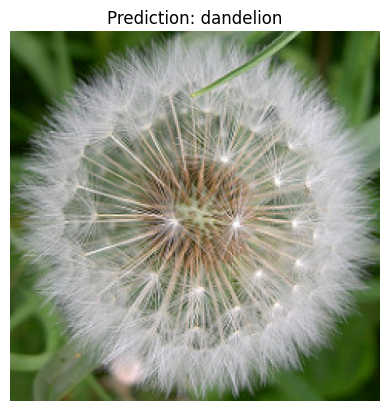


📸 Predicting for: 44079668_34dfee3da1_n.jpg
✅ Raw Model Output: [[ 0.7410508  -0.39302474 -4.8490624   7.8694954  -2.2855651 ]]
✅ Softmax Probabilities: [[8.0108299e-04 2.5772408e-04 2.9917305e-06 9.9889934e-01 3.8836031e-05]]
✅ Predicted Class Index: 3
✅ Predicted Flower: sunflower


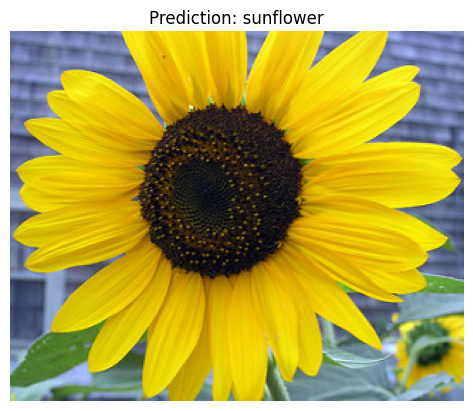


📸 Predicting for: 5673551_01d1ea993e_n.jpg
✅ Raw Model Output: [[ 4.1943464  -0.19726077 -2.6355782   3.0626988  -4.4665956 ]]
✅ Softmax Probabilities: [[7.4842656e-01 9.2661297e-03 8.0900395e-04 2.4136867e-01 1.2964323e-04]]
✅ Predicted Class Index: 0
✅ Predicted Flower: daisy


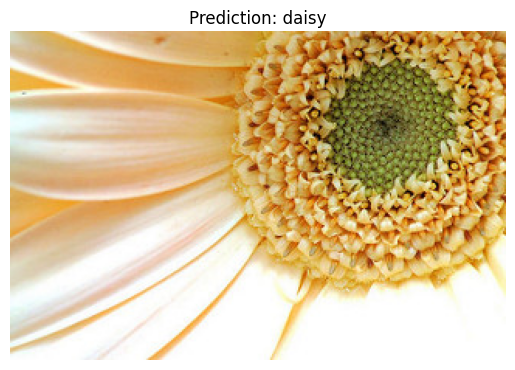


📸 Predicting for: 11545123_50a340b473_m.jpg
✅ Raw Model Output: [[ 1.0573112  3.5979843 -2.1052382 -1.5876609 -1.844055 ]]
✅ Softmax Probabilities: [[0.07216838 0.9156876  0.003054   0.00512449 0.00396552]]
✅ Predicted Class Index: 1
✅ Predicted Flower: dandelion


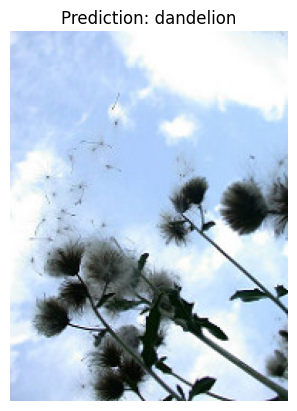


📸 Predicting for: 466486216_ab13b55763.jpg
✅ Raw Model Output: [[-0.9167537 -3.6267557  5.512883  -3.8191462  0.9632303]]
✅ Softmax Probabilities: [[1.5933116e-03 1.0601366e-04 9.8777163e-01 8.7459644e-05 1.0441607e-02]]
✅ Predicted Class Index: 2
✅ Predicted Flower: rose


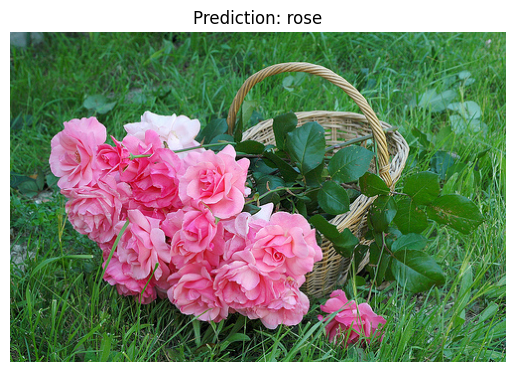


📸 Predicting for: 459042023_6273adc312_n.jpg
✅ Raw Model Output: [[-4.457648  -6.033292   7.3671155 -4.141303   4.1533704]]
✅ Softmax Probabilities: [[7.0379060e-06 1.4559610e-06 9.6133089e-01 9.6567283e-06 3.8651034e-02]]
✅ Predicted Class Index: 2
✅ Predicted Flower: rose


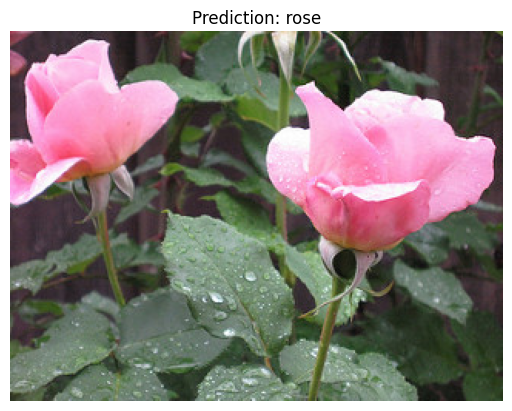

In [36]:
predict_files = os.listdir(predict_dir)

for file_name in predict_files:
    file_path = os.path.join(predict_dir, file_name)
    print(f"\n📸 Predicting for: {file_name}")
    predict_image(file_path)
